- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5
- https://quokkas.tistory.com/37 : early stopping
- https://continuous-development.tistory.com/166 : stratified kfold
- https://deep-learning-study.tistory.com/476 fiter 시각화
- https://wyatt37.tistory.com/10 : random over sampling

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys

p = os.path.abspath('../..') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


# SVD 문장 데이터에서 Feature 추출
- mfcc

In [2]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=16000
win_length =  np.int64(sr/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

# 데이터 나누기 - Stratified KFold

- pathology : 1194 / healthy : 634 / 총 1828
- k = 5

## 1. test/ train 나누기


In [3]:
#1. train, test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


pathology = glob('D:/project/voice_pathology_ai/voice_data/organics/pathology/phrase/*.wav')
healthy = glob('D:/project/voice_pathology_ai/voice_data/organics/healthy/phrase/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))

pathology= [ path.split("\\")[-1] for path in pathology] # path 데이터 변환.
healthy= [ path.split("\\")[-1] for path in healthy] # path 데이터 변환.
 # path 데이터 변환 #외부데이터로 가져오기위해서, 번호만 남긴다

    
X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<597:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=456)
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")

Pathology :  597
Healthy:  634
총 데이터수 :  1231
---
훈련 셋 :  984 Counter({'healthy': 507, 'pathology': 477})
테스트 셋 :  247 Counter({'healthy': 127, 'pathology': 120})
---


## 2. stratified k-fold

In [4]:
#1. train, test 나누기
#stratified kfold
import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



skf_iris = StratifiedKFold(n_splits=5,shuffle=True,random_state=456)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_valid_list = []
Y_valid_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_valid = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_valid = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    Y_train_list.append(Y_train)
    Y_valid_list.append(Y_valid)
    
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_valid
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')



교차 검증 : 1
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 381}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 96} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 381}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 96} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {'healthy': 405, 'pathology': 382}
검증 레이블 데이터 분포 : 
 {'healthy': 102, 'pathology': 95} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {'healthy': 405, 'pathology': 382}
검증 레이블 데이터 분포 : 
 {'healthy': 102, 'pathology': 95} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 382}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 95} 



## 3. random over sampling

In [5]:
#2. random over sampling
for i in range(5):
    X_temp = np.array(X_train_list[i]).reshape(-1,1)#각 데이터를 다 행으로 넣음. (1194,1)
    #Y = np.array(Y)
    ros = RandomOverSampler(random_state = 123)
    X_res,Y_res = ros.fit_resample(X_temp,Y_train_list[i])
    
    print("\n fold{} ".format(i))
    print('before dataset shape {}'.format(Counter(Y_train_list[i])) )
    print('Resampled dataset shape {}'.format(Counter(Y_res)) )   
    
    #원래대로 돌리기
    X_res=X_res.reshape(1, -1)
    X_train_list[i]=X_res[0].tolist()
    Y_train_list[i]=Y_res





 fold0 
before dataset shape Counter({'healthy': 406, 'pathology': 381})
Resampled dataset shape Counter({'pathology': 406, 'healthy': 406})

 fold1 
before dataset shape Counter({'healthy': 406, 'pathology': 381})
Resampled dataset shape Counter({'healthy': 406, 'pathology': 406})

 fold2 
before dataset shape Counter({'healthy': 405, 'pathology': 382})
Resampled dataset shape Counter({'pathology': 405, 'healthy': 405})

 fold3 
before dataset shape Counter({'healthy': 405, 'pathology': 382})
Resampled dataset shape Counter({'pathology': 405, 'healthy': 405})

 fold4 
before dataset shape Counter({'healthy': 406, 'pathology': 382})
Resampled dataset shape Counter({'pathology': 406, 'healthy': 406})


In [6]:
import pickle

 
#load
with open("D:/project/voice_pathology_ai/voice_data/organics/phrase_sig_dict.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)

    

# 데이터 정의
- 추가적으로 데이터의 크기를 맞춰주기 위해 3초로 padding 및 truncate 실시 https://sequencedata.tistory.com/25 FixAudioLength
- 논문에서는 400frame으로 설정.(여기서는 500frame)
- 전처리 방법 결정.


In [7]:
class FrequencyCut(object):
    """spectrogram fft
    """
    def __init__(self,):
        pass

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        if random.uniform(0,1)>0.5:
            f = np.fft.fft2(img)
            fshift = np.fft.fftshift(f)
            magnitude_spectrum = 20*np.log(np.abs(fshift))
            rows,cols = f.shape
            crow,ccol = (int)(rows/2),(int)(cols/2)
            fshift[crow-10:crow+10, ccol-10:ccol+10] = 0
            f_ishift = np.fft.ifftshift(fshift)
            img_back = np.fft.ifft2(f_ishift)
            img_back = np.abs(img_back)
            return img_back
        return img

In [8]:
from torch.utils.data import Dataset, DataLoader

classes = ["pathology","healthy"]
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,transform=None,augment=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset.get_label(self.path_list,training,data_num)
        self.classes=classes
        self.transform=transform
        self.augment=augment
        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 224프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig= phrase_dict[self.path_list[idx]] # 16000hz 실시
        
        
        #stft 500 FRAME이 되도록 패딩.
        length = 300
        mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
        mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
        #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm
        
        pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        mel_feature = pad2d(mel_feature, length)
        
        
        if self.transform:
            #print('transform')
            if self.training:
                mel_feature=self.augment(mel_feature)
                
            mel_feature=self.transform(mel_feature).type(torch.float32)# 데이터 0~1 정규화
            mel_feature=torch.stack([mel_feature,mel_feature,mel_feature])# 3채널로 복사.
            mel_feature = mel_feature.squeeze(dim=1)

            
        else:
            #print("else")
            mel_feature = torch.from_numpy(mel_feature).type(torch.float32)
            mel_feature=mel_feature.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return mel_feature, self.classes.index(self.label[idx])
    

In [9]:
# test set 제작을 위한 class
class svd_test_set(Dataset):
    def __init__(self,data_path_list,classes,transform=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.label = svd_test_set.get_label(self.path_list)
        self.classes=classes
        self.transform=transform
        
    
    @classmethod
    def get_label(cls,data_path_list):
        label_list=[]
        
        for idx,x in enumerate(data_path_list):
            label_list.append(Y_test[idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 224프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig= phrase_dict[self.path_list[idx]] # 16000hz 실시
        
        
        #stft 500 FRAME이 되도록 패딩.
        length = 300
        mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
        mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
        #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm
        
        pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        mel_feature = pad2d(mel_feature, length)
        
        
        if self.transform:
            #print('transform')
            mel_feature=self.transform(mel_feature).type(torch.float32)# 데이터 0~1 정규화
            mel_feature=torch.stack([mel_feature,mel_feature,mel_feature])# 3채널로 복사.
            mel_feature = mel_feature.squeeze(dim=1)
        else:
            #print("else")
            mel_feature = torch.from_numpy(mel_feature).type(torch.float32)
            mel_feature=mel_feature.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return mel_feature, self.classes.index(self.label[idx])
    
    

# 데이터 로더

In [10]:
#3. 하이퍼 파라미터
BATCH_SIZE =  32 #한 배치당 32개 음성데이터
EPOCHS = 40 # 전체 데이터 셋을 50번 반복

In [11]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인
#transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_train_list,
                                               classes,
                                               transform=transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                               augment=transforms.Compose([
                                                   FrequencyCut(),
                                               ]),
                                               data_num=0,
                                               training=True
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.

validation_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_valid_list,
                                               classes,
                                               transform=transforms.ToTensor(),
                                               data_num=0,
                                               training=False
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,) 



In [12]:
# 테스트 데이터 로더.

test_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_test_set(
                                                   X_test,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 

# 데이터 확인

X_train :  torch.Size([32, 3, 128, 300]) type: torch.FloatTensor
Y_train :  torch.Size([32]) type: torch.LongTensor
tensor(0)


Text(0.5, 1.0, 'Spectrogram (dB)')

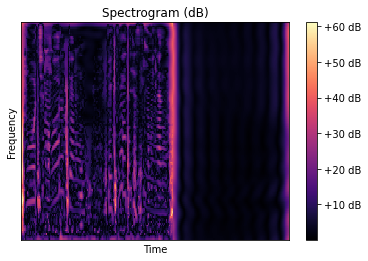

In [13]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0])
librosa.display.specshow(X_train[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_valid :  torch.Size([32, 3, 128, 300]) type: torch.FloatTensor
Y_valid :  torch.Size([32]) type: torch.LongTensor
tensor(0)


Text(0.5, 1.0, 'Spectrogram (dB)')

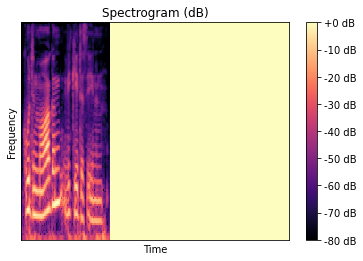

In [14]:
#valiation set 확인
for (X_valid,Y_valid) in validation_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0])
librosa.display.specshow(X_valid[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_valid :  torch.Size([32, 3, 128, 300]) type: torch.FloatTensor
Y_valid :  torch.Size([32]) type: torch.LongTensor
tensor(0)


Text(0.5, 1.0, 'Spectrogram (dB)')

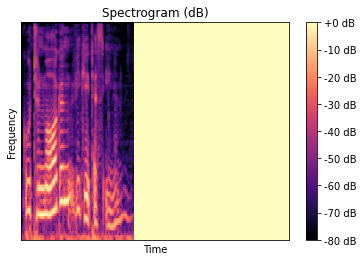

In [15]:
#valiation set 확인
for (test_data,test_label) in validation_loader:
    print("X_valid : ",test_data.size(),'type:',test_data.type())
    print("Y_valid : ",test_label.size(),'type:',test_label.type())
    break

print(Y_valid[0])
librosa.display.specshow(test_data[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

# RESNET

In [16]:
# 모델 
# pretrained


def model_initialize():
    model = models.resnet18(pretrained=True).cuda()
    model.ftrs = model.fc.in_features # in_features : fully connected의 입력수.
    num_ftrs = model.fc.in_features
    
    model.fc = nn.Sequential(nn.Linear(num_ftrs, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )

    model = model.cuda()
    return model
model=model_initialize()


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# get the model summary
from torchsummary import summary
#summary(model, input_size=(3, 128, 300), device=DEVICE.type)

In [19]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [20]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [21]:
#데이터 로더 제작 함수

def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                                   augment=transforms.Compose([
                                                       FrequencyCut(),
                                                   ]),
                                                   data_num=data_ind,
                                                   training=True
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               ) # 순서가 암기되는것을 막기위해.

    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_valid_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                                   data_num=data_ind,
                                                   training=False
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 
    return train_loader,validation_loader



In [22]:
#10. 학습 및 평가.
# resnet34 pretrained true
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,6):

    check_path = '../../checkpoint/checkpoint_melspectro_resnet18_true_ros_'+str(data_ind)+'_organics_aug.pt'
    print(check_path)
    early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)
    
    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)


        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)
            
            


../../checkpoint/checkpoint_melspectro_resnet18_true_ros_1_organics_aug.pt
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0219	 Train Acc:58.74 %  | 	Valid Loss:0.0208 	Valid Acc: 68.02 %

Validation loss decreased (inf --> 0.020797).  Saving model ...

[EPOCH:2]	 Train Loss:0.0189	 Train Acc:68.47 %  | 	Valid Loss:0.0207 	Valid Acc: 70.56 %

Validation loss decreased (0.020797 --> 0.020688).  Saving model ...

[EPOCH:3]	 Train Loss:0.0166	 Train Acc:75.25 %  | 	Valid Loss:0.0178 	Valid Acc: 80.20 %

Validation loss decreased (0.020688 --> 0.017823).  Saving model ...

[EPOCH:4]	 Train Loss:0.0153	 Train Acc:78.69 %  | 	Valid Loss:0.0169 	Valid Acc: 76.14 %

Validation loss decreased (0.017823 --> 0.016901).  Saving model ...

[EPOCH:5]	 Train Loss:0.0136	 Train Acc:83.25 %  | 	Valid Loss:0.0158 	Valid Acc: 78.68 %

Validation loss decreased (0.016901 --> 0.015839).  Saving model ...

[EPOCH:6]	 Train Loss:0.0128	 Train Acc:85.10 %  | 	Valid Loss:0.0155 	Valid Acc: 77.66 %

Validation


[EPOCH:10]	 Train Loss:0.0094	 Train Acc:91.85 %  | 	Valid Loss:0.0134 	Valid Acc: 86.29 %

Validation loss decreased (0.014138 --> 0.013427).  Saving model ...

[EPOCH:11]	 Train Loss:0.0089	 Train Acc:94.32 %  | 	Valid Loss:0.0146 	Valid Acc: 79.19 %

EarlyStopping counter: 1 out of 5

[EPOCH:12]	 Train Loss:0.0084	 Train Acc:94.20 %  | 	Valid Loss:0.0114 	Valid Acc: 87.82 %

Validation loss decreased (0.013427 --> 0.011415).  Saving model ...

[EPOCH:13]	 Train Loss:0.0076	 Train Acc:94.81 %  | 	Valid Loss:0.0126 	Valid Acc: 83.76 %

EarlyStopping counter: 1 out of 5

[EPOCH:14]	 Train Loss:0.0069	 Train Acc:96.42 %  | 	Valid Loss:0.0193 	Valid Acc: 79.70 %

EarlyStopping counter: 2 out of 5

[EPOCH:15]	 Train Loss:0.0071	 Train Acc:95.68 %  | 	Valid Loss:0.0119 	Valid Acc: 84.26 %

EarlyStopping counter: 3 out of 5

[EPOCH:16]	 Train Loss:0.0059	 Train Acc:97.16 %  | 	Valid Loss:0.0134 	Valid Acc: 80.71 %

EarlyStopping counter: 4 out of 5

[EPOCH:17]	 Train Loss:0.0053	 Train Acc

# Model 결과 확인

In [23]:
sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

[1 교차검증] train ACC : 97.2906 |	 valid ACC: 81.2183 
[2 교차검증] train ACC : 89.0394 |	 valid ACC: 84.2640 
[3 교차검증] train ACC : 89.5062 |	 valid ACC: 79.6954 
[4 교차검증] train ACC : 94.1975 |	 valid ACC: 87.8173 
[5 교차검증] train ACC : 89.7783 |	 valid ACC: 86.7347 
평균 검증 정확도 83.94592354708381 %


# Model Test

- test set
- confusion matrix

In [26]:
#confusion matrix 계산
#test set 계산.
def test_evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            
        return predictions,answers,test_loss
            

In [27]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0

for data_ind in range(1,6):

    check_path = '../../checkpoint/checkpoint_melspectro_resnet18_true_ros_'+str(data_ind)+'_organics.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers,test_loss = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    precision=cf[0,0]/(cf[0,0]+cf[1,0])
    recall=cf[0,0]/(cf[0,0]+cf[0,1])
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))




1번 모델
Accuracy : 85.0202% 
Precision (pathology 예측한 것중 맞는 것) : 0.7986
recall (실제 pathology 중  예측이 맞는 것) : 0.9250
f score : 0.8498 
[[111   9]
 [ 28  99]]
-----
2번 모델
Accuracy : 85.8300% 
Precision (pathology 예측한 것중 맞는 것) : 0.8512
recall (실제 pathology 중  예측이 맞는 것) : 0.8583
f score : 0.8582 
[[103  17]
 [ 18 109]]
-----
3번 모델
Accuracy : 85.8300% 
Precision (pathology 예측한 것중 맞는 것) : 0.9126
recall (실제 pathology 중  예측이 맞는 것) : 0.7833
f score : 0.8569 
[[ 94  26]
 [  9 118]]
-----
4번 모델
Accuracy : 87.0445% 
Precision (pathology 예측한 것중 맞는 것) : 0.8860
recall (실제 pathology 중  예측이 맞는 것) : 0.8417
f score : 0.8701 
[[101  19]
 [ 13 114]]
-----
5번 모델
Accuracy : 88.2591% 
Precision (pathology 예측한 것중 맞는 것) : 0.9027
recall (실제 pathology 중  예측이 맞는 것) : 0.8500
f score : 0.8822 
[[102  18]
 [ 11 116]]
-----
평균 acc : 0.8640
평균 f1score : 0.8635


# 기타

In [ ]:
#크기 알아보기
#일반 CNN

m = nn.MaxPool2d(2, stride=2)
#m = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(32, 1, 500, 13)
print(input.size())
output = m(input)
print(output.size())
output = m(output)
print(output.size())

In [ ]:
#크기 알아보기
#주파수 영역 CNN

input = torch.randn(32, 1, 500, 13)
m=nn.Conv2d(
            in_channels = 1,# 채널이 1개
            out_channels = 32,# FeatureMap 수,커널 수
            kernel_size = (1,13),#1x13  no padding
        )
output=m(input)
print(output.size())
m=nn.Conv2d(
            in_channels = 32,# 채널이 1개
            out_channels = 64,# FeatureMap 수,커널 수
            kernel_size = (27,1),#9 x 1 no padding
        )
output=m(output)
print(output.size())


In [ ]:
input = torch.randn(500, 13)

out=torch.stack([input,input,input])
out.size()

In [ ]:
all_train_accs
all_valid_accs

all_train_loss_list
all_valid_loss_list



In [ ]:
length=300
mel_feature=pathology[0]
transform_norm = transforms.ToTensor()

pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
mel_feature = pad2d(mel_feature, length)
mel_feature = transform_norm(mel_feature)




In [ ]:
mel_feature

In [ ]:
librosa.util.normalize(mel_feature.squeeze().numpy())

In [ ]:
mel_feature.size()

In [ ]:
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image

#model.eval()

#pathology 음성 파일 가져오기

length=300
mel_sample=healthy[0]
image_list=[]
transform_norm = transforms.ToTensor()

pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
mel_sample = pad2d(mel_sample, length)
mel_sample = transform_norm(mel_sample)
mel_sample=torch.stack([mel_sample,mel_sample,mel_sample])# 3채널로 복사.
mel_sample=mel_sample.squeeze(1)
mel_sample=mel_sample.unsqueeze(0).to(DEVICE).float()
print(mel_sample.squeeze()[0])


In [ ]:
mel_sample.squeeze()[0]

# grad cam
- https://www.secmem.org/blog/2020/01/17/gradcam/
- https://blog.naver.com/PostView.nhn?blogId=domodal&logNo=221485292052&parentCategoryNo=&categoryNo=10&viewDate=&isShowPopularPosts=true&from=search
- f1-score가 가장높은 5번 모델 cam 확인
- 마지막 feature map 부터 output 까지의 gradient를 계산해야한다.
- https://sanghyu.tistory.com/46 normalize

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys

p = os.path.abspath('../..') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.



if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

In [ ]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

pathology_sig=[]
healthy_sig=[]

pathology=[]
healthy=[]



#PATHOLOGY DATA
for audio_path in os.listdir('../../../voice_data/pathology_new/phrase/export'):
    sig, sr = librosa.load('../../../voice_data/pathology_new/phrase/export/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    pathology_sig.append(sig)
    mel_feature = librosa.feature.melspectrogram(sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    pathology.append(mel_feature)
    

#Healthy data
for audio_path in os.listdir('../../../voice_data/healthy_new/phrase/export'):
    sig, sr = librosa.load('../../../voice_data/healthy_new/phrase/export/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    healthy_sig.append(sig)
    mel_feature = librosa.feature.melspectrogram(sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    healthy.append(mel_feature)
    
print("pathology data 수 : ",len(pathology))
print("healthy data 수 : ",len(healthy))


path_max=max([ len(samples) for samples in pathology_sig])
healthy_max=max([ len(samples) for samples in healthy_sig])
print("가장 긴 path sample :" ,path_max)
print("가장 긴 healthy sample :" ,healthy_max)

In [ ]:
# final conv layer name 
finalconv_name = 'layer4'

# activations
feature_blobs = []

# gradient를 가져올 hook 함수
backward_feature = []

transform_norm = transforms.ToTensor()

# output으로 나오는 feature를 feature_blobs에 append하도록
def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data.numpy()) # 레이어의 마지막 output(피처맵)을 구하는 함수
    

# Grad-CAM
def backward_hook(module, input, output):
    backward_feature.append(output[0])  #backward시에 그래디언트 저장.

In [ ]:
# 모델 수정해서 hook 추가 사용.



def model_initialize():
    model = models.resnet18(pretrained=True).cuda()
    model.ftrs = model.fc.in_features # in_features : fully connected의 입력수.
    num_ftrs = model.fc.in_features
    
    model.layer4.register_forward_hook(hook_feature)
    model.layer4.register_backward_hook(backward_hook)
    
    model.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                             nn.BatchNorm1d(256),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(256,128),
                             nn.BatchNorm1d(128),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(128,64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )

    model = model.cuda()
    return model
model=model_initialize()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

check_path = '../../checkpoint/checkpoint_melspectro_resnet18_true_ros_1_300.pt'
model.load_state_dict(torch.load(check_path))
print(model)


In [ ]:
grad_result[]

마지막 cnn layer는 layer4로 볼 수 있다.

In [ ]:
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

model.eval()

#pathology 음성 파일 가져오기

length=300
mel_sample=pathology[0]
image_list=[]

# activations
feature_blobs = []

# gradient를 가져올 hook 함수
backward_feature = []


pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
mel_sample = pad2d(mel_sample, length)
mel_sample = transform_norm(mel_sample)
mel_sample=torch.stack([mel_sample,mel_sample,mel_sample])# 3채널로 복사.
mel_sample=mel_sample.squeeze(1)
mel_sample=mel_sample.unsqueeze(0).to(DEVICE).float()


model._modules.get(finalconv_name).register_forward_hook(hook_feature)
model._modules.get(finalconv_name).register_backward_hook(backward_hook)



# Prediction
logit = model(mel_sample) # 예측값 구하기.
out = F.softmax(logit, dim=1).data.squeeze() # softmax 적용 (모델을 통과는 했지만, criterion는 안통과함.)
probs, idx = out.sort(0, True)
print("Predicted label : %d, Probability : %.2f" % (idx[0].item(), probs[0].item()))

###########
# Grad - cam
###########

score = logit[:, idx[0]].squeeze() # 예측값 y^c.
score.backward(retain_graph = True) # 예측값 y^c에 대해서 backprop 진행
    
activations = torch.Tensor(feature_blobs[0]).to(DEVICE) # (1, 512, 7, 7), forward activations. append라서 0번이 마지막
gradients = backward_feature[0] # (1, 512, 4, 10), backward gradients. 마지막 conv layer의 gradient
b, k, u, v = gradients.size()  # batch, 피처맵 수,  상, 하
print(gradients.size())

alpha = gradients.view(b, k, -1).mean(2) # (1, 512, 7*7) => (1, 512), feature map k의 'importance'
weights = alpha.view(b, k, 1, 1) # (1, 512, 1, 1)

grad_cam_map = (weights*activations).sum(1, keepdim = True) # alpha * A^k = (1, 512, 7, 7) => (1, 1, 7, 7)
grad_cam_map = F.relu(grad_cam_map) # Apply R e L U
grad_cam_map = F.interpolate(grad_cam_map, size=(128, 300), mode='bilinear', align_corners=False) # (1, 1, 224, 224)
map_min, map_max = grad_cam_map.min(), grad_cam_map.max()
grad_cam_map = (grad_cam_map - map_min).div(map_max - map_min).data # (1, 1, 128, 300), min-max scaling

grad_heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map.squeeze().cpu()), cv2.COLORMAP_JET) # (224, 224, 3), numpy 
grad_heatmap = torch.from_numpy(grad_heatmap).permute(2, 0, 1).float().div(255) # (3, 244, 244)



#save_image(grad_heatmap, os.path.join("./", "Grad_CAM.jpg"))
r=torch.from_numpy(scaler.fit_transform(mel_sample.squeeze().cpu()[0]))
g=torch.from_numpy(scaler.fit_transform(mel_sample.squeeze().cpu()[1]))
b=torch.from_numpy(scaler.fit_transform(mel_sample.squeeze().cpu()[2]))

grad_result = grad_heatmap + torch.stack([r,g,b]) # (1, 3, 128, 300)
grad_result = grad_result.div(grad_result.max()).squeeze().permute(1, 2, 0)


#mel_sample = librosa.util.normalize(mel_sample.cpu().squeeze().numpy()[0])

#grad_result = grad_heatmap.numpy() + mel_sample # (1, 3, 244, 244)


plt.figure(figsize=(15,10))


plt.subplot(131)
librosa.display.specshow(mel_sample.cpu().squeeze().numpy()[0], sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")


plt.subplot(132)
plt.imshow(grad_heatmap.permute(1, 2, 0).numpy())
plt.gca().invert_yaxis()

plt.subplot(133)
plt.imshow(grad_result)
plt.gca().invert_yaxis()


In [ ]:
torch.stack([r,g,b]).size()

In [ ]:
mel_sample.shape

In [ ]:
grad_result.size()

In [ ]:
np.min(grad_result.permute(1, 2, 0).numpy())

In [ ]:
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image

model.eval()

#pathology 음성 파일 가져오기

length=300
mel_sample=pathology[50]
image_list=[]

# activations
feature_blobs = []

# gradient를 가져올 hook 함수
backward_feature = []


pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
mel_sample = pad2d(mel_sample, length)
mel_sample = transform_norm(mel_sample)
mel_sample=torch.stack([mel_sample,mel_sample,mel_sample])# 3채널로 복사.
mel_sample=mel_sample.squeeze(1)
mel_sample=mel_sample.unsqueeze(0).to(DEVICE).float()


model._modules.get(finalconv_name).register_forward_hook(hook_feature)
model._modules.get(finalconv_name).register_backward_hook(backward_hook)



# Prediction
logit = model(mel_sample) # 예측값 구하기.
out = F.softmax(logit, dim=1).data.squeeze() # softmax 적용 (모델을 통과는 했지만, criterion는 안통과함.)
probs, idx = out.sort(0, True)
print("Predicted label : %d, Probability : %.2f" % (idx[0].item(), probs[0].item()))

###########
# Grad - cam
###########

score = logit[:, idx[0]].squeeze() # 예측값 y^c.
score.backward(retain_graph = True) # 예측값 y^c에 대해서 backprop 진행
    
activations = torch.Tensor(feature_blobs[0]).to(DEVICE) # (1, 512, 7, 7), forward activations. append라서 0번이 마지막
gradients = backward_feature[0] # (1, 512, 4, 10), backward gradients. 마지막 conv layer의 gradient
b, k, u, v = gradients.size()  # batch, 피처맵 수,  상, 하
print(gradients.size())

alpha = gradients.view(b, k, -1).mean(2) # (1, 512, 7*7) => (1, 512), feature map k의 'importance'
weights = alpha.view(b, k, 1, 1) # (1, 512, 1, 1)

grad_cam_map = (weights*activations).sum(1, keepdim = True) # alpha * A^k = (1, 512, 7, 7) => (1, 1, 7, 7)
grad_cam_map = F.relu(grad_cam_map) # Apply R e L U
grad_cam_map = F.interpolate(grad_cam_map, size=(128, 300), mode='bilinear', align_corners=False) # (1, 1, 224, 224)
map_min, map_max = grad_cam_map.min(), grad_cam_map.max()
grad_cam_map = (grad_cam_map - map_min).div(map_max - map_min).data # (1, 1, 128, 300), min-max scaling
    
grad_heatmap=grad_cam_map.squeeze().cpu()
# grad_cam_map.squeeze() : (128, 300)

save_image(grad_heatmap, os.path.join("./", "Grad_CAM.jpg"))





mel_sample = librosa.util.normalize(mel_sample.cpu().squeeze().numpy()[0])

grad_result = grad_heatmap.numpy() + mel_sample # (1, 3, 244, 244)


plt.figure(figsize=(20,15))

plt.subplot(331)
librosa.display.specshow(mel_sample, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")


plt.subplot(332)
librosa.display.specshow(grad_heatmap.numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

plt.subplot(333)
librosa.display.specshow(grad_result, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")



In [ ]:
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image

model.eval()

#pathology 음성 파일 가져오기

length=300
mel_sample=healthy[0]
image_list=[]


pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
mel_sample = pad2d(mel_sample, length)
mel_sample = transform_norm(mel_sample)
mel_sample=torch.stack([mel_sample,mel_sample,mel_sample])# 3채널로 복사.
mel_sample=mel_sample.squeeze(1)
mel_sample=mel_sample.unsqueeze(0).to(DEVICE).float()
print(mel_sample)

model._modules.get(finalconv_name).register_forward_hook(hook_feature)
model._modules.get(finalconv_name).register_backward_hook(backward_hook)



# Prediction
logit = model(mel_sample) # 예측값 구하기.
out = F.softmax(logit, dim=1).data.squeeze() # softmax 적용 (모델을 통과는 했지만, criterion는 안통과함.)
probs, idx = out.sort(0, True)
print("Predicted label : %d, Probability : %.2f" % (idx[0].item(), probs[0].item()))

###########
# Grad - cam
###########

score = logit[:, idx[0]].squeeze() # 예측값 y^c.
score.backward(retain_graph = True) # 예측값 y^c에 대해서 backprop 진행
    
activations = torch.Tensor(feature_blobs[0]).to(DEVICE) # (1, 512, 7, 7), forward activations. append라서 0번이 마지막
gradients = backward_feature[0] # (1, 512, 4, 10), backward gradients. 마지막 conv layer의 gradient
b, k, u, v = gradients.size()  # batch, 피처맵 수,  상, 하
print(gradients.size())

alpha = gradients.view(b, k, -1).mean(2) # (1, 512, 7*7) => (1, 512), feature map k의 'importance'
weights = alpha.view(b, k, 1, 1) # (1, 512, 1, 1)

grad_cam_map = (weights*activations).sum(1, keepdim = True) # alpha * A^k = (1, 512, 7, 7) => (1, 1, 7, 7)
grad_cam_map = F.relu(grad_cam_map) # Apply R e L U
grad_cam_map = F.interpolate(grad_cam_map, size=(128, 300), mode='bilinear', align_corners=False) # (1, 1, 224, 224)
map_min, map_max = grad_cam_map.min(), grad_cam_map.max()
grad_cam_map = (grad_cam_map - map_min).div(map_max - map_min).data # (1, 1, 128, 300), min-max scaling
    
grad_heatmap=grad_cam_map.squeeze().cpu()
# grad_cam_map.squeeze() : (128, 300)

save_image(grad_heatmap, os.path.join("./", "Grad_CAM.jpg"))





mel_sample = librosa.util.normalize(mel_sample.cpu().squeeze().numpy()[0])

grad_result = grad_heatmap.numpy() + mel_sample # (1, 3, 244, 244)


plt.figure(figsize=(20,15))

plt.subplot(331)
librosa.display.specshow(mel_sample, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")


plt.subplot(332)
librosa.display.specshow(grad_heatmap.numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

plt.subplot(333)
librosa.display.specshow(grad_result, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")



In [ ]:
plt.imshow(grad_heatmap*255)

In [ ]:
mel_feature

In [ ]:
grad_heatmap.permute(1,2,0).size()

In [ ]:
backward_feature[0]

In [ ]:
activations # 피처맵

In [ ]:
logit[:, idx[0]].squeeze() 

In [ ]:
backward_feature

In [ ]:
out

In [ ]:
datas = Variable(mel_feature)#  미분가능한 torch 데이터로 변환되고
feature = datas.data
print(feature.size())

In [ ]:
datas